In [1]:
from pipeline import Pipeline
from stopwords import stopwords
import json 
import io
from datetime import datetime
import csv
import string
import os
import re
import itertools
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

def build_csv(lines, header=None, file=None):
    if header:
        lines = itertools.chain([header], lines)
    writer = csv.writer(file, delimiter=',')
    writer.writerows(lines)
    file.seek(0)
    return file

pipeline = Pipeline() 

@pipeline.task()
def file_to_json():
    with open('hn_stories_2014.json','r') as file:
        json_data = json.load(file)
        stories = json_data['stories']
        
    return stories

@pipeline.task(depends_on = file_to_json)
def filter_stories(stories):
    def most_pop(story):
        return story['points'] > 50 and story['num_comments'] > 1 and not story['title'].startswith('Ask HN')
        
    return (s for s in stories if most_pop(s))


@pipeline.task(depends_on = filter_stories)
def json_to_csv(stories):
    header = ['objectID','created_at','url','points','title']
    story_list = []
    
    for s in stories:
        story_list.append([s['objectID'], datetime.strptime(s['created_at'], "%Y-%m-%dT%H:%M:%SZ"),\
                     s['url'], s['points'], s['title']])
    
    return build_csv(story_list, header = header, file = io.StringIO())


@pipeline.task(depends_on = json_to_csv)
def extract_titles(file_obj):
    reader = csv.reader(file_obj)
    header = next(reader)
    i =  header.index('title')
    return (line[i] for line in reader)


@pipeline.task(depends_on = extract_titles)
def clean_titles(titles):
    
    for title in titles:
        title = title.lower()
        title = re.sub('[^A-Za-z]',' ', title)
        yield title
    

@pipeline.task(depends_on = clean_titles)
def build_keyword_dictionary(titles):
    word_dict = {}
    for title in titles:
        for word in title.split(" "):
            if word and word not in stopwords:
                if word not in word_dict:
                    word_dict[word] = 0
                word_dict[word] += 1
    return word_dict
    

@pipeline.task(depends_on=build_keyword_dictionary)
def top_keywords(word_freq):
    key = [[k,word_freq[k]] for k in sorted(word_freq, key=word_freq.__getitem__, reverse=True)]
    df = pd.DataFrame(key, columns=['keyword','frequency'])
    return df

# save information in postegreSQL
import psycopg2
@pipeline.task(depends_on=top_keywords)
def extractSQL(df):
    conn = psycopg2.connect(dbname="postgres",user="postgres")
    cursor = conn.cursor()
    cursor.execute("DROP TABLE if exists HackerNews")
    cursor.execute("CREATE TABLE HackerNews(year integer, keyword text PRIMARY KEY, frequency integer)")
    for i in range(len(df)):
        key,freq = df.iloc[i,]
        cursor.execute("INSERT INTO HackerNews VALUES (%s, %s, %s)", (2014, key, int(freq)))
    conn.commit()
    conn.close()

@pipeline.task(depends_on=top_keywords)
def barplot30(df):
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.bar(range(len(df.iloc[0:30,0])), df.iloc[0:30,1],color = ['gold'],edgecolor = "none" )
    plt.suptitle('HackerNews top keywords in 2014')
    plt.xlabel('Keyword')
    plt.ylabel('Frequency')


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
keyword,hn,google,show,new,open,bitcoin,web,programming,data,source,facebook,video,python,code,free
frequency,211,194,192,188,126,106,99,91,87,86,84,81,81,75,72


,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
keyword,using,js,released,app,internet,javascript,one,game,world,time,go,first,linux,apple,microsoft
frequency,72,71,71,68,67,66,66,66,65,64,64,63,62,61,60


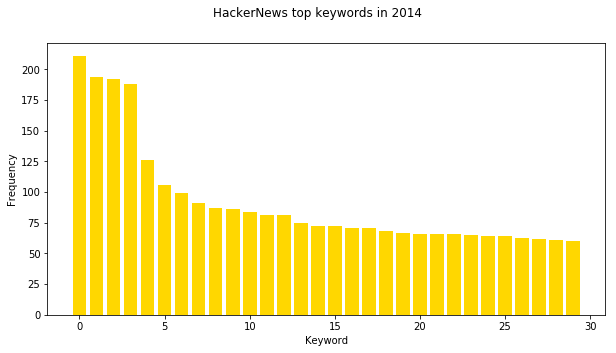

In [2]:
os.chdir("C:\\Users\Robbie\Desktop\intern\portfolio\HackerNewsPipeline")
ran = pipeline.run()
display(ran[top_keywords][:15].T)
display(ran[top_keywords][15:30].T)

In [7]:
conn = psycopg2.connect(dbname="postgres",user="postgres")
cur = conn.cursor()
cur.execute('SELECT * FROM HackerNews WHERE frequency > 100')
for i in cur.fetchall():
    print(i)
conn.close()

(2014, 'hn', 211)
(2014, 'google', 194)
(2014, 'show', 192)
(2014, 'new', 188)
(2014, 'open', 126)
(2014, 'bitcoin', 106)
